In [118]:
import init_notebook
from os import makedirs
import numpy as np
import matplotlib.pyplot as plt
from typing import NamedTuple
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import solve_ivp

from sir_model import R0, model, mu, h

Reproduction number R0= 0.9956709956709958
Globally asymptotically stable if beta <=d+nu+mu0. This is False


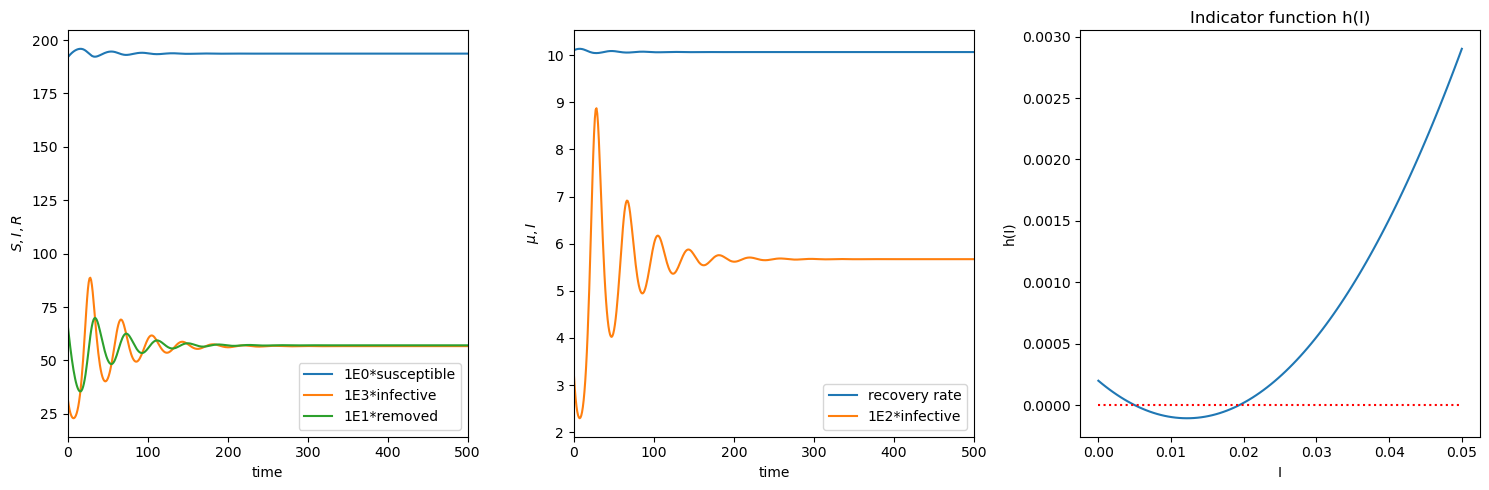

In [119]:
# parameters
random_state = 12345
t_0 = 0
t_end = 1000
NT = t_end-t_0
# if these error tolerances are set too high, the solution will be qualitatively (!) wrong
rtol=1e-8
atol=1e-8

# SIR model parameters
beta=11.5
A=20
d=0.1
nu=1
b=0.01 # try to set this to 0.01, 0.020, ..., 0.022, ..., 0.03
mu0 = 10   # minimum recovery rate
mu1 = 10.45  # maximum recovery rate

# information
print("Reproduction number R0=", R0(beta, d, nu, mu1))
print('Globally asymptotically stable if beta <=d+nu+mu0. This is', beta <= d+nu+mu0)

# simulation
rng = np.random.default_rng(random_state)

SIM0 = rng.uniform(low=(190, 0, 1), high=(199,0.1,8), size=(3,))
time = np.linspace(t_0,t_end,NT)
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='LSODA', rtol=rtol, atol=atol)

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(sol.t, sol.y[0]-0*sol.y[0][0], label='1E0*susceptible');
ax[0].plot(sol.t, 1e3*sol.y[1]-0*sol.y[1][0], label='1E3*infective');
ax[0].plot(sol.t, 1e1*sol.y[2]-0*sol.y[2][0], label='1E1*removed');
ax[0].set_xlim([0, 500])
ax[0].legend();
ax[0].set_xlabel("time")
ax[0].set_ylabel(r"$S,I,R$")

ax[1].plot(sol.t, mu(b, sol.y[1], mu0, mu1), label='recovery rate')
ax[1].plot(sol.t, 1e2*sol.y[1], label='1E2*infective');
ax[1].set_xlim([0, 500])
ax[1].legend();
ax[1].set_xlabel("time")
ax[1].set_ylabel(r"$\mu,I$")

I_h = np.linspace(-0.,0.05,100)
ax[2].plot(I_h, h(I_h, mu0, mu1, beta, A, d, nu, b));
ax[2].plot(I_h, 0*I_h, 'r:')
#ax[2].set_ylim([-0.1,0.05])
ax[2].set_title("Indicator function h(I)")
ax[2].set_xlabel("I")
ax[2].set_ylabel("h(I)")

fig.tight_layout()

In [120]:
def plot_orbit(initial_value, b, save=True):
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_subplot(111,projection="3d")
    time = np.linspace(t_0,1500000,NT)
    cmap = ["BuPu", "Purples", "bwr"][1]

    sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=initial_value, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)

    ax.plot(sol.y[0], sol.y[1], sol.y[2], 'r-')
    ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap='bwr')
    ax.plot(initial_value[0], initial_value[1], initial_value[2], color='#03fc13', marker='o')

    ax.set_xlabel("S")
    ax.set_ylabel("I")
    ax.set_zlabel("R")

    ax.set_title(f"SIR Orbit (b={b})") 
    fig.tight_layout()
    if save:
        try:
            makedirs(f'task_5/orbits')
        except FileExistsError:
            pass
        fig.savefig(f'task_5/orbits/P=({initial_value[0]},{initial_value[1]},{initial_value[2]}),b={b}.png', format='png')


SIM0 = [195.3, 0.052, 4.4] # what happens with this initial condition when b=0.022? -- it progresses VERY slowly. Needs t_end to be super large.
plot_orbit(SIM0, 0.02204)

SIM1 = [195.7, 0.03, 3.92] # what happens with this initial condition when b=0.022?
plot_orbit(SIM1, 0.022)

SIM2 = [193, 0.08, 6.21] # what happens with this initial condition when b=0.022?
plot_orbit(SIM2, 0.022)

In [ ]:
def float_range(start: float, end: float, step: float):
    current = start
    while current < end:
        yield current
        current += step

class SIR_Solution(NamedTuple):
    b: list
    s: list
    i: list
    r: list
    name: str

def find_solutions(initial_value, plot_percentage=0.02, b_start=0.1, b_end=0.3,n_points=1000) -> SIR_Solution:
    t_end = 150000
    time = np.linspace(t_0,t_end,NT)
    display(f'Solving from b={b_start} to b={b_end}. Sampling {n_points} b values.')

    b_sol=[]
    s_sol=[]
    i_sol=[]
    r_sol=[]

    for b in float_range(b_start, b_end, (b_end-b_start)/n_points):
        sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=initial_value, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
        plot_from = len(sol.y[0]) - int(len(sol.y[0]) * plot_percentage)
        b_array = [b] * (len(sol.y[0]) - plot_from)

        b_sol.extend(b_array)
        s_sol.extend(sol.y[0][plot_from:])
        i_sol.extend(sol.y[1][plot_from:])
        r_sol.extend(sol.y[2][plot_from:])
    

    solution_name = f'P=({initial_value[0]},{initial_value[1]},{initial_value[2]}),b_range=({b_start},{b_end},{n_points}),t_end={t_end}'

    return SIR_Solution(b=b_sol, s=s_sol, i=i_sol, r=r_sol, name=solution_name)


In [ ]:
sim0_sol = find_solutions(SIM0, plot_percentage=0.05, b_start=0.01, b_end=0.03, n_points=1000)

'Solving from b=0.01 to b=0.03. Sampling 100 b values.'

In [ ]:
sim1_sol = find_solutions(SIM1, plot_percentage=0.05, b_start=0.01, b_end=0.03, n_points=1000)

'Solving from b=0.01 to b=0.03. Sampling 100 b values.'

In [ ]:
sim2_sol = find_solutions(SIM2, plot_percentage=0.05, b_start=0.01, b_end=0.03, n_points=1000)

'Solving from b=0.01 to b=0.03. Sampling 100 b values.'

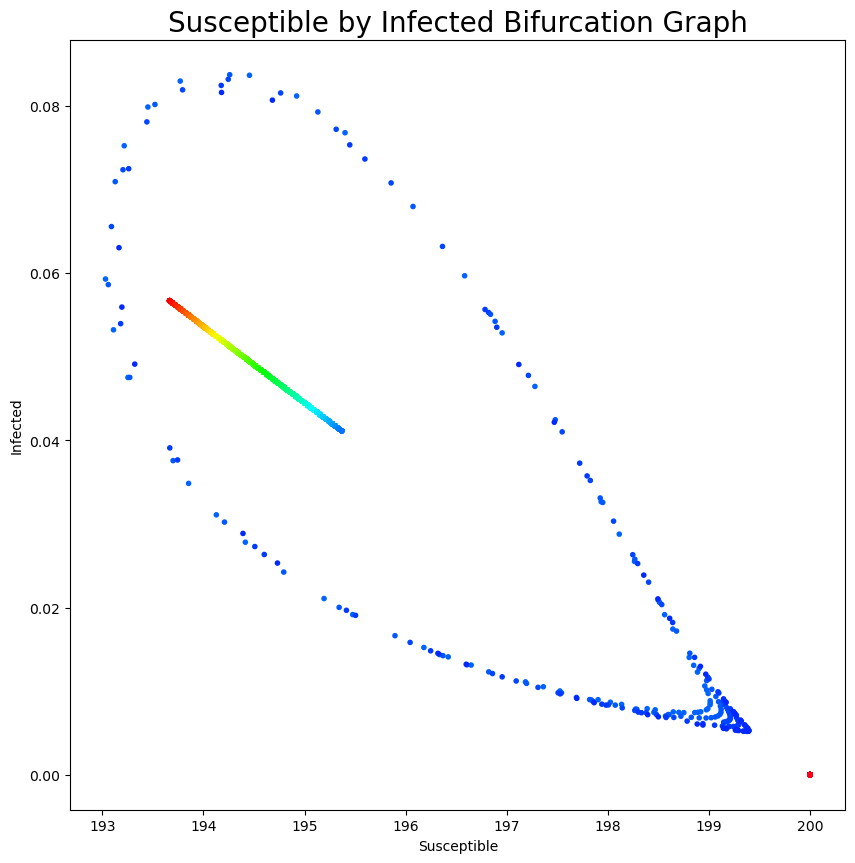

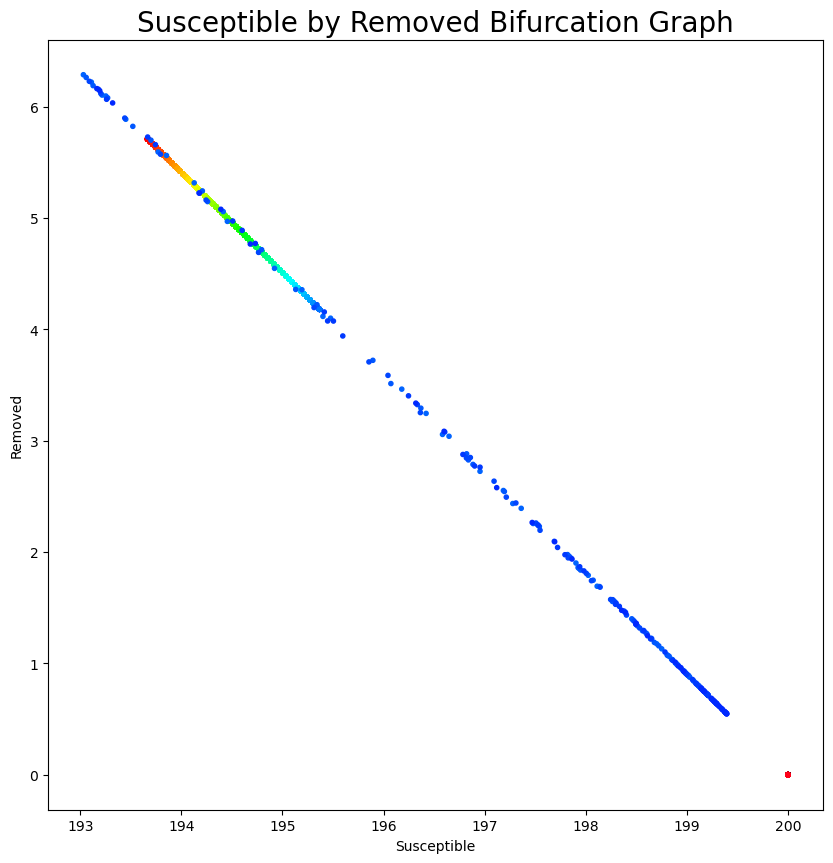

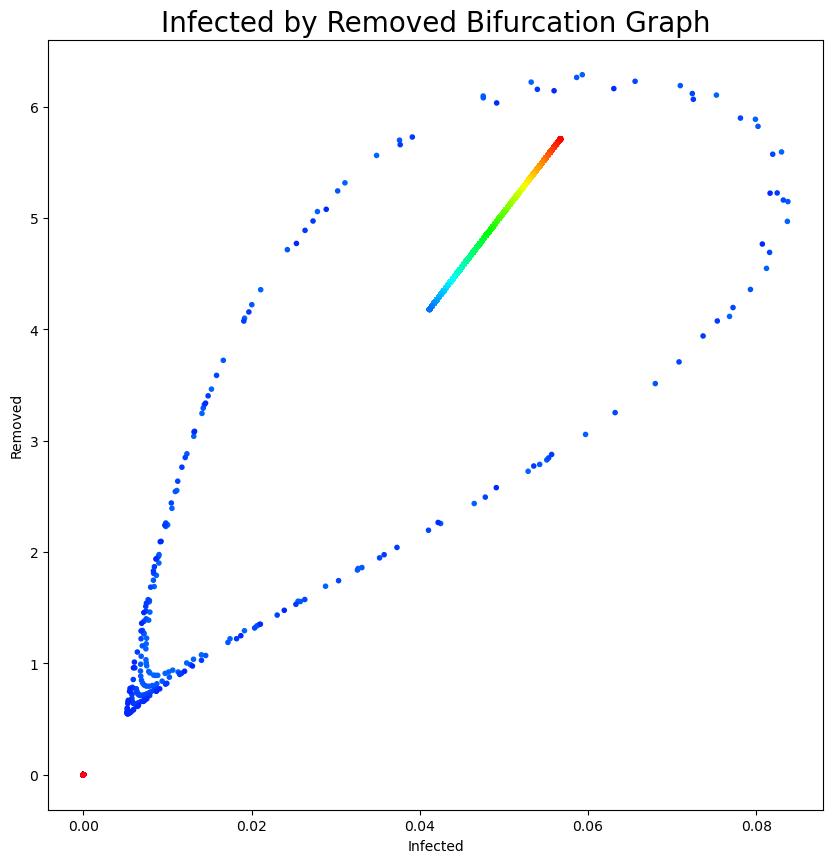

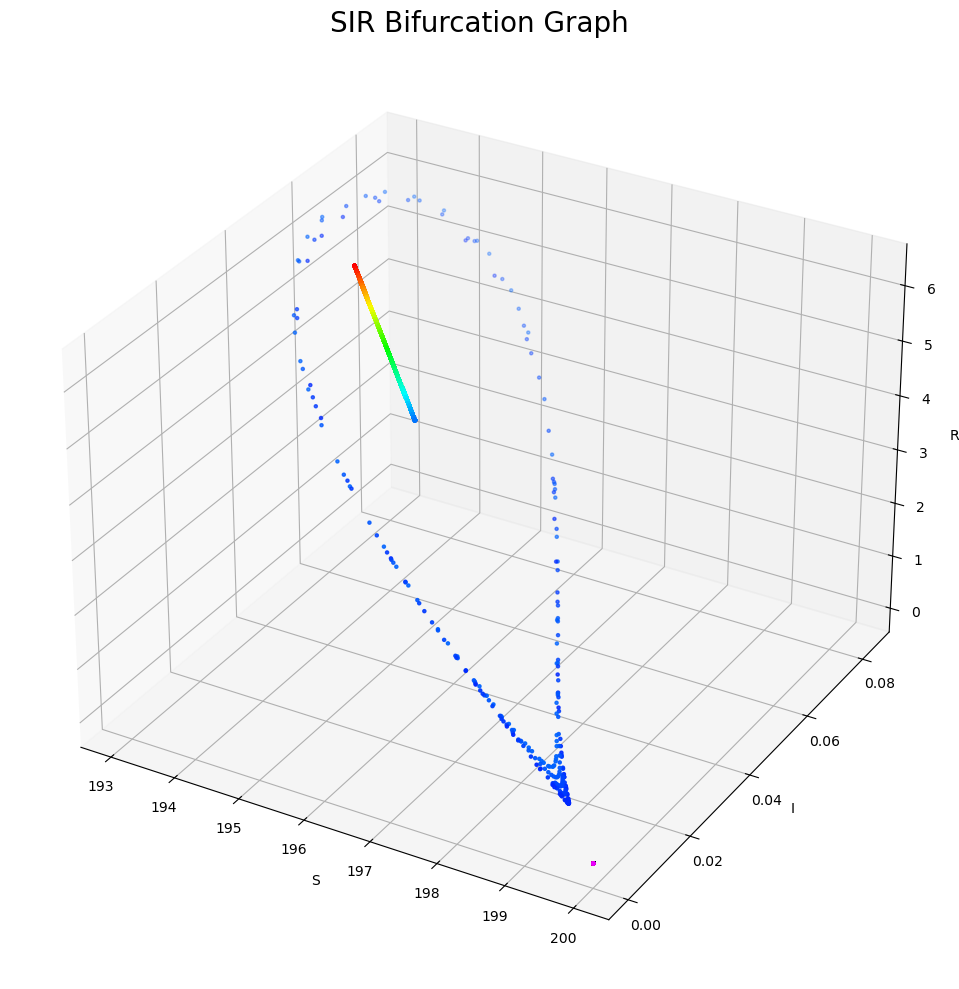

In [ ]:
def divergence_plots(solution: SIR_Solution, save=True):

    figures= {}
    
    fig=plt.figure(figsize=(10,10))
    figures['si_plot'] = fig
    s_graph=fig.add_subplot(111)
    s_graph.scatter(solution.s, solution.i, marker=".",c=solution.b, cmap='hsv')
    s_graph.set_xlabel("Susceptible", fontsize=20)
    s_graph.set_ylabel("Infected", fontsize=20)
    s_graph.set_title("Susceptible by Infected Bifurcation Graph", fontsize=20)

    fig=plt.figure(figsize=(10,10))
    figures['sr_plot'] = fig
    i_graph=fig.add_subplot(111)
    i_graph.scatter(solution.s, solution.r, marker=".",c=solution.b, cmap='hsv')
    i_graph.set_xlabel("Susceptible", fontsize=20)
    i_graph.set_ylabel("Removed", fontsize=20)
    i_graph.set_title("Susceptible by Removed Bifurcation Graph", fontsize=20) 

    fig=plt.figure(figsize=(10,10))
    figures['ir_plot'] = fig
    r_graph=fig.add_subplot(111)
    r_graph.scatter(solution.i, solution.r, marker=".",c=solution.b, cmap='hsv')
    r_graph.set_xlabel("Infected", fontsize=20)
    r_graph.set_ylabel("Removed", fontsize=20)
    r_graph.set_title("Infected by Removed Bifurcation Graph", fontsize=20) 

    fig=plt.figure(figsize=(10,10))
    figures['sir_plot'] = fig
    sir_graph=fig.add_subplot(111, projection='3d')
    sir_graph.scatter(solution.s, solution.i, solution.r, marker=".",c=solution.b, cmap='hsv')
    sir_graph.set_xlabel("S", fontsize=20)
    sir_graph.set_ylabel("I", fontsize=20)
    sir_graph.set_zlabel("R", fontsize=20)
    sir_graph.set_title("SIR Bifurcation Graph", fontsize=20) 


    fig.tight_layout()
    if save:
        try:
            makedirs(f'task_5/{solution.name}')
        except FileExistsError:
            pass
        
        for fig_name, fig in figures.items():
            fig.savefig(f'task_5/{solution.name}/{fig_name}.png', format='png')

divergence_plots(sim0_sol)
#divergence_plots(sim1_sol)
#divergence_plots(sim2_sol)